<b>Continuous Skip-gram Model:</b><br/>
Intuition: words with similar meanings often occur near each
other in texts. <br/>
Given a word w: <br/>
<ul>
    <li> Predict each neighboring word in  a context window of 2L words form the current window</li>
    <li> For L =2, we predict its 4 neighbouring words (2 each side) </li>
</ul>

Learn 2 embeddings for each word w_j in V: 
        



In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict, Counter
import tensorflow as tf
import random
import time
#os.listdir('small_dataset')

In [6]:
# All methods

def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

def read_in_words(filename):
    file = open(filename,'r')
    text = file.read()
    words = preprocess(text)
    return words

def get_vocabulary_counts(word_set):
    counts = defaultdict(lambda:0)
    for word in word_set:
        counts[word] += 1
    return counts

def get_subsample_probs(freqs,t):
    n = sum([freqs[x] for x in list(freqs.keys())])
    prob_dict = defaultdict(float)
    for word in V_dict.keys():
        count = V_dict[word]
        f_w = count/n # Relative frequency
        P_keep = 1 - np.sqrt(t/f_w)
        prob_dict[word] = P_keep
    return prob_dict
    
def subsample(words, counts,threshold=0.001):
    # Source: Mikolov et al., "Distributed representations of words
    #  and phrases and their compositionality" (2013)
    # We remove words from a dataset with a probability related 
    # to the frequency of the word occurance. Frequent words 
    # are deleted more often than non-frequent words. This is done
    # to reduce the number of training samples needed.
    # Probability for removal is computed as
    #
    # P(w_i) = 1 - sqrt(t/(f(w_i)))
    #
    # Where f(w_i) is the relative frequency of word w_i and t a 
    # chosen treshold (typically 0.00001). This does not work for 
    # a small dataset. So if
    # Returns subsampled sentence set
    n = sum([counts[x] for x in list(counts.keys())])
    freqs = {word: counts[word]/n for word in list(counts.keys())}
    
    word_probs = {word: 1-np.sqrt(threshold/freqs[word]) for word in freqs.keys()}
    # word_probs['the'] returns the probability to drop 'the'
    
   
    new_words = [word for word in words if random.random() < 1-(word_probs[word])]
    
    return new_words
    

def get_targets(words, idx, W):
    # Returns words with a random window size in range of W
    R = np.random.randint(1,W+1)
    ixlo = max(idx-R,0)
    ixhi = min(idx+R+1,len(words))
    targets = set([word for word in words[ixlo:ixhi] if word != words[idx]])
    return list(targets)



    
def one_hot(word_int,V):
    v = np.zeros(V,dtype=int)
    v[word_int] = 1
    return v


In [4]:
# Surpress deprication warnings

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [3]:
# Parameters

W = 5 # Window size
H = 300 # Number of neurons in hidden/embedding layer
epochs = 10 # number of epochs
batch_size = 1000

In [7]:
# Building data
start = time.time()
words_text = read_in_words('large_dataset/training.en')
# Get word counts from the corpus
counts = get_vocabulary_counts(words_text)
# Subsample corpus based on word counts/frequencies.
word_set = subsample(words_text,counts)


# Get distinct words from corpus
words = set(word_set)
# Build usefull word2int and reverse dictionary.
word2int={word:i for i,word in enumerate(words)}
int2word={i:word for i,word in enumerate(words)}
train_words = [word2int[word] for word in word_set]
V = len(words) # Vocabulary size
print("Reading in and preprocessing data took {} seconds.".format(time.time()-start))


Reading in and preprocessing data took 4.3976733684539795 seconds.


In [8]:
print("{} words in vocabulary.".format(V))

13130 words in vocabulary.


In [13]:
def get_batches(words, batch_size, W):
    n_batches = len(words) // batch_size
    print("Num batches: {}".format(n_batches))
    words = words[:n_batches*batch_size]
    for i in range(0,len(words),batch_size):
        x,y = [],[]
        batch = words[i:i+batch_size]
        for j in range(len(batch)):
            batch_x = batch[j]
            batch_y = get_targets(batch,j,W)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x,y


# Model architecture
g = tf.Graph()

with g.as_default():
    # Input words
    inputs = tf.placeholder(tf.int32,[None],name='inputs')
    # Words that appear in the context of these input words
    labels = tf.placeholder(tf.int32, [None,None],name='labels')
    # The embedding matrix that we want to obtain/ train
    embedding = tf.Variable(tf.random_uniform((V, H), -1, 1))
    
    # This gives the hidden layer output for each of the inputs
    embed = tf.nn.embedding_lookup(embedding, inputs)
    
    # The weights between the hidden layer output and 
    softmax_w = tf.Variable(tf.truncated_normal((V,H)))
    softmax_b = tf.Variable(tf.zeros(V),name='softmax_bias')
    loss = tf.nn.sampled_softmax_loss(
        weights = softmax_w,
        biases  = softmax_b,
        labels  = labels,
        inputs  = embed,
        num_sampled = 100,
        num_classes = V)
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    saver = tf.train.Saver()

    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))
    


print("Starting training")
with tf.Session(graph=g) as sess:
    i = 1
    loss = 0
    init = tf.global_variables_initializer()
    sess.run(init)
    print("Starting first epoch")
    for e in range(1,epochs+1):

        batches = get_batches(train_words,batch_size,W)

        start = time.time()
        
        for x,y in batches:
            # for each batch
            feed = {inputs:x,
                    labels: np.array(y)[:,None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            loss += train_loss
            if i % 100 == 0:
                print("Epoch {}/{}".format(e,epochs),
                      "Iteration {}".format(i),
                     "Avg. Trainig loss: {:.4f}".format(loss/100),
                     "{:.4f} sec/batch".format((time.time()-start)/100))
                loss = 0
                start = time.time()
            if i % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int2word[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int2word[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            i += 1
    save_path = saver.save(sess,"checkpoints/text8.ckpt")

Starting training
Starting first epoch
Num batches: 2463
Epoch 1/10 Iteration 100 Avg. Trainig loss: 19.7249 0.0268 sec/batch
Epoch 1/10 Iteration 200 Avg. Trainig loss: 18.9003 0.0261 sec/batch
Epoch 1/10 Iteration 300 Avg. Trainig loss: 18.0446 0.0258 sec/batch
Epoch 1/10 Iteration 400 Avg. Trainig loss: 17.3803 0.0255 sec/batch
Epoch 1/10 Iteration 500 Avg. Trainig loss: 16.7233 0.0260 sec/batch
Epoch 1/10 Iteration 600 Avg. Trainig loss: 16.0903 0.0262 sec/batch
Epoch 1/10 Iteration 700 Avg. Trainig loss: 15.4355 0.0265 sec/batch
Epoch 1/10 Iteration 800 Avg. Trainig loss: 14.8723 0.0257 sec/batch
Epoch 1/10 Iteration 900 Avg. Trainig loss: 14.2408 0.0256 sec/batch
Epoch 1/10 Iteration 1000 Avg. Trainig loss: 13.5682 0.0206 sec/batch
Nearest to worries: burned, requesting, mouths, ubc, levied, treasuries, 206, grouping,
Nearest to peer: remaining, regard, petitioners, dick, cruel, excludes, sisters, lucrative,
Nearest to ix: successes, fiduciary, year, question, herron, desperation

Epoch 2/10 Iteration 100 Avg. Trainig loss: 4.9410 0.0220 sec/batch
Epoch 2/10 Iteration 200 Avg. Trainig loss: 5.4450 0.0261 sec/batch
Epoch 2/10 Iteration 300 Avg. Trainig loss: 5.5573 0.0256 sec/batch
Epoch 2/10 Iteration 400 Avg. Trainig loss: 5.4777 0.0256 sec/batch
Epoch 2/10 Iteration 500 Avg. Trainig loss: 5.4641 0.0261 sec/batch
Epoch 2/10 Iteration 600 Avg. Trainig loss: 5.3295 0.0259 sec/batch
Epoch 2/10 Iteration 700 Avg. Trainig loss: 5.2640 0.0255 sec/batch
Epoch 2/10 Iteration 800 Avg. Trainig loss: 5.1020 0.0258 sec/batch
Epoch 2/10 Iteration 900 Avg. Trainig loss: 5.0165 0.0258 sec/batch
Num batches: 2463
Epoch 3/10 Iteration 1000 Avg. Trainig loss: 5.0141 0.0037 sec/batch
Nearest to worries: requesting, 206, relevant, shore, mouths, 46, burned, eighth,
Nearest to peer: remaining, regard, petitioners, yea, supply, dick, 24, disease,
Nearest to ix: successes, fiduciary, herron, desperation, year, sable, roth, kelly,
Nearest to mozambique: ltd, vigorously, prerogatives, 

Epoch 4/10 Iteration 100 Avg. Trainig loss: 2.9870 0.0221 sec/batch
Epoch 4/10 Iteration 200 Avg. Trainig loss: 3.5654 0.0260 sec/batch
Epoch 4/10 Iteration 300 Avg. Trainig loss: 3.4375 0.0259 sec/batch
Epoch 4/10 Iteration 400 Avg. Trainig loss: 3.2847 0.0259 sec/batch
Epoch 4/10 Iteration 500 Avg. Trainig loss: 3.2942 0.0262 sec/batch
Epoch 4/10 Iteration 600 Avg. Trainig loss: 3.2744 0.0266 sec/batch
Epoch 4/10 Iteration 700 Avg. Trainig loss: 3.4842 0.0263 sec/batch
Epoch 4/10 Iteration 800 Avg. Trainig loss: 3.2966 0.0257 sec/batch
Epoch 4/10 Iteration 900 Avg. Trainig loss: 3.2283 0.0252 sec/batch
Epoch 4/10 Iteration 1000 Avg. Trainig loss: 3.2897 0.0262 sec/batch
Nearest to worries: requesting, 206, shore, burned, grouping, 46, treasuries, definitive,
Nearest to peer: remaining, yea, regard, petitioners, heed, supply, lucrative, dick,
Nearest to ix: herron, successes, fiduciary, desperation, year, lasted, situations, teeth,
Nearest to mozambique: prerogatives, ltd, vigorously,

Epoch 5/10 Iteration 100 Avg. Trainig loss: 2.3613 0.0216 sec/batch
Epoch 5/10 Iteration 200 Avg. Trainig loss: 2.7055 0.0258 sec/batch
Epoch 5/10 Iteration 300 Avg. Trainig loss: 2.5905 0.0256 sec/batch
Epoch 5/10 Iteration 400 Avg. Trainig loss: 2.6809 0.0255 sec/batch
Num batches: 2463
Epoch 6/10 Iteration 500 Avg. Trainig loss: 2.7294 0.0013 sec/batch
Epoch 6/10 Iteration 600 Avg. Trainig loss: 2.5859 0.0263 sec/batch
Epoch 6/10 Iteration 700 Avg. Trainig loss: 2.6279 0.0266 sec/batch
Epoch 6/10 Iteration 800 Avg. Trainig loss: 2.6055 0.0263 sec/batch
Epoch 6/10 Iteration 900 Avg. Trainig loss: 2.5666 0.0261 sec/batch
Epoch 6/10 Iteration 1000 Avg. Trainig loss: 2.6505 0.0260 sec/batch
Nearest to worries: 206, requesting, burned, treasuries, definitive, firms, shore, insisted,
Nearest to peer: remaining, 24, of, happy, regard, budgetary, yea, first,
Nearest to ix: herron, fiduciary, successes, desperation, lasted, teeth, nays, clauses,
Nearest to mozambique: prerogatives, ltd, appe

Epoch 7/10 Iteration 100 Avg. Trainig loss: 2.0415 0.0225 sec/batch
Epoch 7/10 Iteration 200 Avg. Trainig loss: 2.3620 0.0260 sec/batch
Epoch 7/10 Iteration 300 Avg. Trainig loss: 2.3888 0.0259 sec/batch
Epoch 7/10 Iteration 400 Avg. Trainig loss: 2.2504 0.0259 sec/batch
Epoch 7/10 Iteration 500 Avg. Trainig loss: 2.3778 0.0258 sec/batch
Epoch 7/10 Iteration 600 Avg. Trainig loss: 2.3421 0.0258 sec/batch
Epoch 7/10 Iteration 700 Avg. Trainig loss: 2.3190 0.0257 sec/batch
Epoch 7/10 Iteration 800 Avg. Trainig loss: 2.3322 0.0258 sec/batch
Epoch 7/10 Iteration 900 Avg. Trainig loss: 2.3919 0.0260 sec/batch
Epoch 7/10 Iteration 1000 Avg. Trainig loss: 2.2615 0.0260 sec/batch
Nearest to worries: 206, requesting, <SEMICOLON>, treasuries, area, definitive, burned, pontiac,
Nearest to peer: remaining, householder, until, lucrative, unlawfully, budgetary, burned, happy,
Nearest to ix: herron, successes, fiduciary, desperation, lasted, nays, clauses, teeth,
Nearest to mozambique: ltd, prerogati

Epoch 9/10 Iteration 100 Avg. Trainig loss: 1.8922 0.0227 sec/batch
Epoch 9/10 Iteration 200 Avg. Trainig loss: 2.1048 0.0261 sec/batch
Epoch 9/10 Iteration 300 Avg. Trainig loss: 2.1649 0.0266 sec/batch
Epoch 9/10 Iteration 400 Avg. Trainig loss: 2.0255 0.0263 sec/batch
Epoch 9/10 Iteration 500 Avg. Trainig loss: 2.1354 0.0257 sec/batch
Epoch 9/10 Iteration 600 Avg. Trainig loss: 2.0891 0.0261 sec/batch
Epoch 9/10 Iteration 700 Avg. Trainig loss: 2.1296 0.0260 sec/batch
Epoch 9/10 Iteration 800 Avg. Trainig loss: 2.0697 0.0258 sec/batch
Epoch 9/10 Iteration 900 Avg. Trainig loss: 1.9959 0.0281 sec/batch
Epoch 9/10 Iteration 1000 Avg. Trainig loss: 2.0325 0.0273 sec/batch
Nearest to worries: 206, requesting, treasuries, firms, occupies, explicitly, pontiac, rights,
Nearest to peer: remaining, householder, happy, until, damn, budgetary, first, burned,
Nearest to ix: herron, fiduciary, desperation, successes, lasted, clauses, schedule, teeth,
Nearest to mozambique: ltd, prerogatives, pri

Epoch 10/10 Iteration 100 Avg. Trainig loss: 1.6668 0.0224 sec/batch
Epoch 10/10 Iteration 200 Avg. Trainig loss: 1.9291 0.0260 sec/batch
Epoch 10/10 Iteration 300 Avg. Trainig loss: 2.0984 0.0259 sec/batch
Epoch 10/10 Iteration 400 Avg. Trainig loss: 1.9802 0.0256 sec/batch
Epoch 10/10 Iteration 500 Avg. Trainig loss: 1.9947 0.0263 sec/batch
Epoch 10/10 Iteration 600 Avg. Trainig loss: 1.9589 0.0279 sec/batch
Epoch 10/10 Iteration 700 Avg. Trainig loss: 1.8955 0.0269 sec/batch
Epoch 10/10 Iteration 800 Avg. Trainig loss: 1.9883 0.0263 sec/batch
Epoch 10/10 Iteration 900 Avg. Trainig loss: 1.9247 0.0256 sec/batch


In [12]:
# Retrieve trained model
g = tf.Graph()

with g.as_default():
    # Input words
    inputs = tf.placeholder(tf.int32,[None],name='inputs')
    # Words that appear in the context of these input words
    labels = tf.placeholder(tf.int32, [None,None],name='labels')
    # The embedding matrix that we want to obtain/ train
    embedding = tf.Variable(tf.random_uniform((V, H), -1, 1))
    
    # This gives the hidden layer output for each of the inputs
    embed = tf.nn.embedding_lookup(embedding, inputs)
    
    # The weights between the hidden layer output and 
    softmax_w = tf.Variable(tf.truncated_normal((V,H)))
    softmax_b = tf.Variable(tf.zeros(V),name='softmax_bias')
    loss = tf.nn.sampled_softmax_loss(
        weights = softmax_w,
        biases  = softmax_b,
        labels  = labels,
        inputs  = embed,
        num_sampled = 100,
        num_classes = V)
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    saver = tf.train.Saver()

with tf.Session(graph=g) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding) # trained embedding matrix :D
    # Check if restore was successful by checking loss
    
    batch = get_batches(train_words,batch_size,W)
    loss = 0
    for i in range(100):
        x,y = next(batch)
        feed = {inputs:x,
            labels: np.array(y)[:,None]}
        train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
        loss += train_loss
    print("Avg. Loss is {}".format(loss/100))
    

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt
Num batches: 2463
Avg. Loss is 10.58930142402649


In [7]:
# Visualize embeddings with t-sne

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [8]:
import operator
sorted_counts = sorted(counts.items(), key=operator.itemgetter(1),reverse=True)
print(sorted_counts[:10])
punc_set = ['.',',',':',';','_','-']
int_words_sorted = [word2int[x] for (x,y) in sorted_counts if x not in punc_set]

[('the', 248285), ('.', 157523), (',', 146960), ('of', 115766), ('to', 112746), ('and', 74796), ('in', 70648), ('that', 69218), ('a', 62202), ('is', 57066)]


In [13]:
print(int_words_sorted[:10])
print(word2int['of'])

[33807, 575, 26080, 34694, 18260, 8310, 21868, 23977, 19564, 25905]
575


In [20]:
# Reduce dimensionality of embedding matrix with 
viz_words = int_words_sorted[:50]
s = time.time()
tsne = TSNE(perplexity=50, n_iter = 1000)
embed_tsne = tsne.fit_transform(embed_mat[viz_words, :])
print('Fitting TSNE took {} seconds'.format(time.time()-s))

Fitting TSNE took 8.88007140159607 seconds


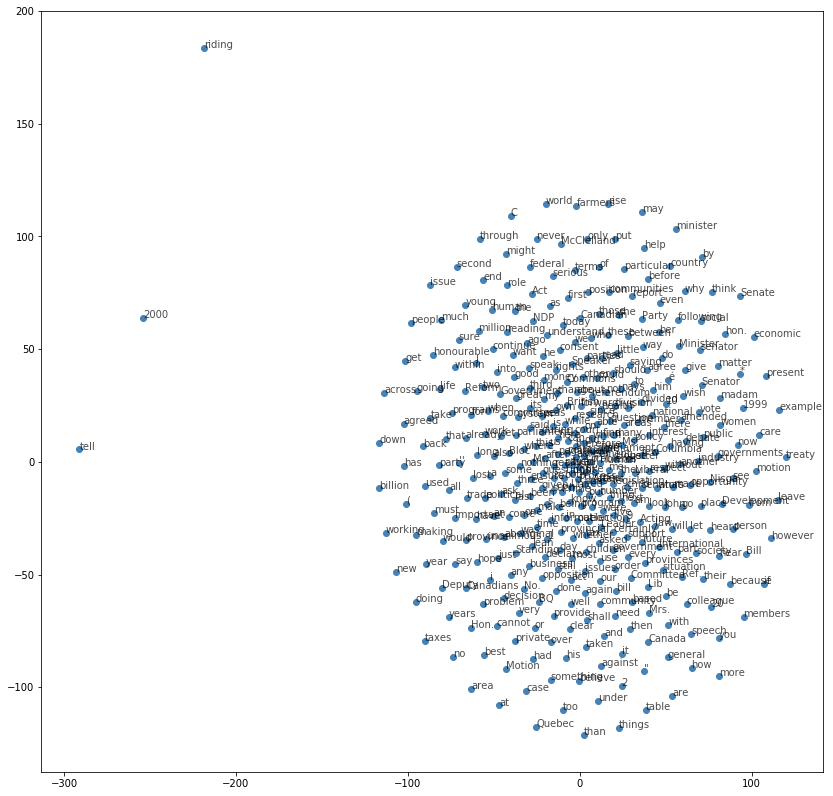

In [21]:
fig, ax = plt.subplots(figsize=(14, 14))
for i,idx in enumerate(viz_words):
    plt.scatter(*embed_tsne[i, :], color='steelblue')
    plt.annotate(int2word[idx], (embed_tsne[i, 0], embed_tsne[i, 1]), alpha=0.7)
plt.show()